# Precipitation trend example

This notebook is a simple demonstration of creating figures showing the predictions of (summer) precipitation change for north-west Europe for a variety of models, and their ensemble mean.

The notebook uses two external processes, `CDO` (Climate Data operators) and `GrADS` (Grid Analysis and Display System), for regridding and processing the models.

Model results are averaged using a rolling mean, after which the ensemble mean is created. This is a straightforward few lines in Pandas. The results are shown using Matplotlib's PyPlot.

Python imports are done at the point where needed. Imports are `iris`, `numpy`, `pandas`, `matplotlib` and `bokeh`.

## Definitions

First, we set our parameters of interest: variable, region, season and a few others, as well as our time range.
We should only have to change any of these and rerun the notebook, to get new results.
Note that intermediate files are named with these variable values in their name.

In [1]:
var = "pr"       # variable of interest.
season = "JJA"   # seaons (June, July, August - summer)
region = "china"

Our models of interest; most are commented-out because of local limitations regarding disk space.

In [2]:
models = [
    'ACCESS1-0', 'ACCESS1-3', 'bcc-csm1-1', 'BNU-ESM',
]

Define the coordinates of all our potential regions of interest.

In [3]:
coords = {
    "global": {
        "west": 0,
        "east": 360,
        "south": -90,
        "north": 90,
    },
    "rhine": {
        "west": 5,
        "east": 10,
        "south": 45,
        "north": 52.5,
    },
    "europe": {
        "west": -11.25,
        "east": 26.25,
        "south": 47.5,
        "north": 52.5,
    },
    "nweurope": {
        "west": 2,
        "east": 15,
        "south": 47,
        "north": 52.5,
    },
    "NL": {
        "west": 5,
        "east": 12.5,
        "south": 47.5,
        "north": 52.5,
    },
    "usa": {
        "west": -118.75,
        "east": -83.75,
        "south": 43.75,
        "north": 56.25,
    },
    "russia": {
        "west": 38.75,
        "east": 86.25,
        "south": 51.25,
        "north": 66.25,
    },
    "china": {
        "west": 108.75,
        "east": 118.75,
        "south": 23.75,
        "north": 31.25,
    },
    "australia": {
        "west": 108.75,
        "east": 121.25,
        "south": -31.25,
        "north": -23.75,
    },
}

Set up our directories for inputs and intermediate files.

In [4]:
datadir = "/mnt/data/data1/extra"

In [5]:
# Get the coordinates for our region of interest
east = coords[region]["east"]
west = coords[region]["west"]
north = coords[region]["north"]
south = coords[region]["south"]
region, east, west, north, south

('china', 118.75, 108.75, 31.25, 23.75)

The following cell reads each dataset, extracts a time selection and the relevant season.
It then averages over the region of interest.
Finally, it uses the average of the first 20 years to define a starting level, which is subtracted from all data.

In [6]:
import os
import iris
import iris.analysis
import iris.analysis.cartography
from iris.coord_categorisation import add_season
from iris.time import PartialDateTime

# This uses Iris constraints to set time intervals for the period of interest, and the starting period to average
time_constraint = iris.Constraint(time=lambda cell: PartialDateTime(1900, 1, 1) < cell.point < PartialDateTime(2049, 12, 31))
time_start_constraint = iris.Constraint(time=lambda cell: PartialDateTime(1900, 1, 1) < cell.point < PartialDateTime(1919, 12, 31))


df = {}
import warnings
with warnings.catch_warnings():
    # iris is far too noisy
    warnings.filterwarnings("ignore", category=UserWarning, module='iris')
    for model in models:
        print(model)
        fname = f"{var}_Amon_{model}_rcp85_r1i1p1.nc"
        inpath = os.path.join(datadir, fname)
        cube = iris.load(inpath)[0]
        
        cube *= 360 * 24 * 365
        
        cube = cube.extract(time_constraint)
        
        # Use an Iris utility to add season information, based on the time coordinate
        add_season(cube, 'time', name='clim_season')
        cube = cube.extract(iris.Constraint(clim_season=season.lower()))
        
        points = [('longitude', [west, east]), ('latitude', [south, north])]
        cube = cube.interpolate(points, iris.analysis.Linear())
        for coord in ('longitude', 'latitude'):
            if not cube.coord(coord).has_bounds():
                cube.coord(coord).guess_bounds()
        weights = iris.analysis.cartography.area_weights(cube, normalize=True)

        cube = cube.collapsed(["longitude", "latitude"], iris.analysis.MEAN, weights=weights)
        startmean = cube.extract(time_start_constraint).data.mean()
        df[model] = cube.data.reshape(-1, 3).mean(axis=1) - startmean

ACCESS1-0
ACCESS1-3
bcc-csm1-1
BNU-ESM


Save the results in a Pandas dataframe.
With the dataframe, we can easily calculate a rolling mean with a window function and calculate the spread in the models.

In [7]:
import pandas as pd
import numpy as np
df = pd.DataFrame(df, index=np.arange(1900, 2050))
df.head()

,ACCESS1-0,ACCESS1-3,bcc-csm1-1,BNU-ESM
1900,-65.719810,5.327042,20.919065,9.533896
1901,-49.931298,33.812512,5.463058,13.550187
1902,-33.056308,-22.127938,-47.978194,-3.923533
1903,7.588948,4.721488,-14.016277,-26.944292
1904,50.686289,62.764577,-0.148826,3.694268


In [8]:
# Calculate the rolling mean
windowsize = 21
rm_models = ['rm-' + model for model in models]
df[rm_models] = df[models].rolling(window=windowsize, center=True).mean()

# Calculat the ensemble mean, and 95% spread
mean = df[rm_models].mean(axis=1)
# ddof is 0, since we have the full population of models; not a sample, where ddof = 1 should have been used.
std = df[rm_models].std(axis=1, ddof=0)

factor = 1.96   # 95% area for normal distribution
df['mean'] = mean
df['lower_95perc'] = mean - factor * std
df['upper_95perc'] = mean + factor * std

# Let's have a look
df.head(15)

,ACCESS1-0,ACCESS1-3,bcc-csm1-1,BNU-ESM,rm-ACCESS1-0,rm-ACCESS1-3,rm-bcc-csm1-1,rm-BNU-ESM,mean,lower_95perc,upper_95perc
1900,-65.719810,5.327042,20.919065,9.533896,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1901,-49.931298,33.812512,5.463058,13.550187,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902,-33.056308,-22.127938,-47.978194,-3.923533,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903,7.588948,4.721488,-14.016277,-26.944292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1904,50.686289,62.764577,-0.148826,3.694268,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1905,-58.248609,-37.543696,95.368576,17.254069,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906,44.505046,-2.353578,-21.923309,-0.442398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1907,61.632515,-65.906820,-71.689172,1.436813,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1908,-70.243056,87.484867,43.883803,-51.154157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1909,116.438471,-30.488970,43.381709,-14.601202,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plotting

Let's do some plotting.
We set some definitions first, then create two plots:
1. Summer precipitation in percentage-change since 1900 versus year, for each model
2. Ensemble mean of the summer precipitation change versus year

In [9]:
from matplotlib import pyplot as plt
RED = 'red'
BLUE = 'blue'

# Styles: see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
# and https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
# NB: substyles of seaborn occasionally require tight_layout()
plt.style.use('seaborn')

# NB: Matplotlib's 'darkgrey' is lighter than plain 'grey'; 'dimgrey' is darker.
plt.rc('xtick', labelsize=14, color='dimgrey')
plt.rc('ytick', labelsize=14, color='dimgrey')
plt.rc('axes', labelsize=16, titlesize=16, labelcolor='dimgrey')

year_ticks = np.arange(1900, 2050, 25)

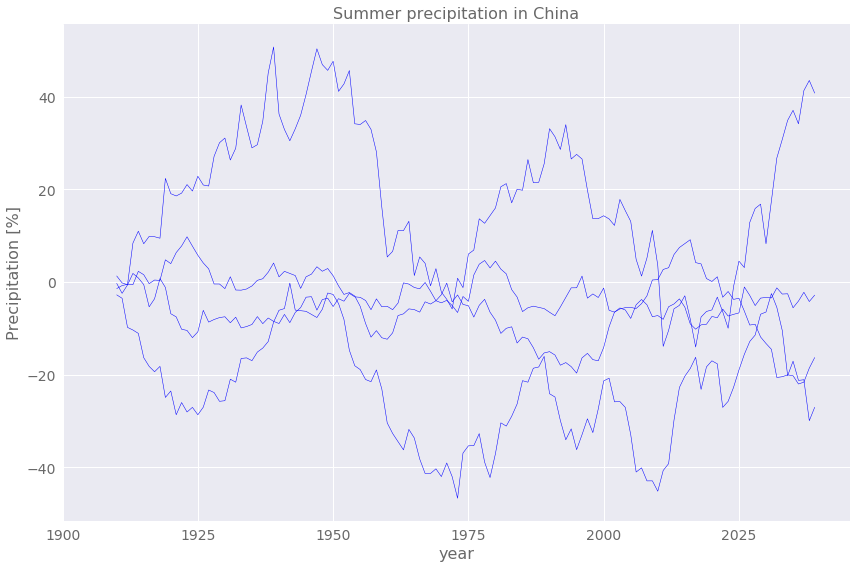

In [10]:
plt.figure(figsize=(12,8))
for model in models:
    # Note: df.index are the years
    plt.plot(df.index, df['rm-'+model], label=model, color=BLUE, linewidth=0.5)
plt.title("Summer precipitation in {}".format(region.capitalize()), color="dimgrey")
plt.xlabel("year")
plt.ylabel("Precipitation [%]")
plt.xticks(year_ticks)
plt.tight_layout()

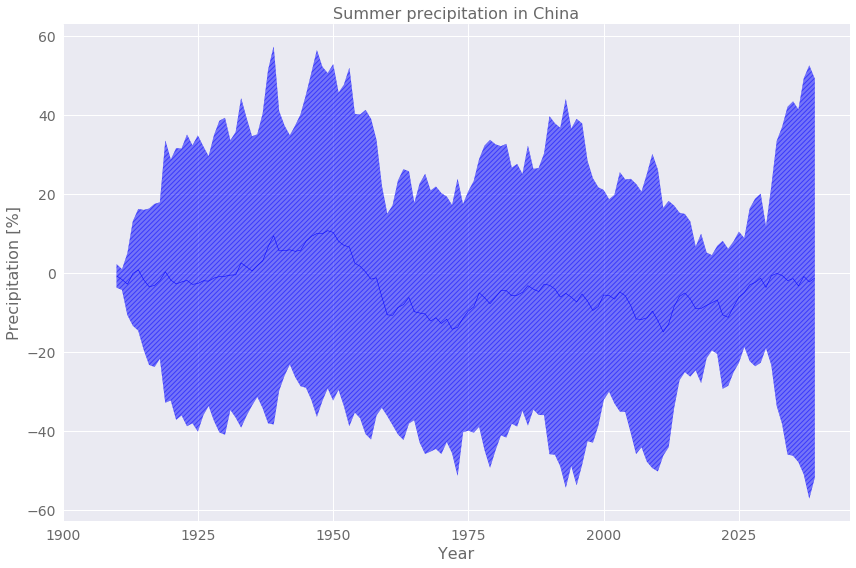

In [11]:
plt.figure(figsize=(12,8))
# Note: df.index are the years
plt.fill_between(df.index, df['lower_95perc'], df['upper_95perc'],
                 color=BLUE, alpha=0.5, hatch='/////')
plt.plot(df.index, df['mean'], label="ensemble mean", color=BLUE, linewidth=0.5)
plt.title("Summer precipitation in {}".format(region.capitalize()), color="dimgrey")
plt.xlabel("Year")
plt.ylabel("Precipitation [%]")
plt.xticks(year_ticks)
plt.tight_layout()

## Interactive plots

For some interactivity, we can use Bokeh. This allows panning and zooming of the figure, as well as turning off and on of datasets, by clicking on their label in the legend.

In [ ]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20

output_notebook()

data = ColumnDataSource(df)
plot = figure(plot_width=800, plot_height=600)
for model, color in zip(models, Category20[20]):
    plot.line(df.index, df['rm-'+model], legend=model, color=color)
plot.legend.click_policy = "hide"    
plot.legend.location = "bottom_left"
plot.legend.background_fill_alpha = 0.5
show(plot)